In [1]:
import pickle
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint

def load_obj(folder, name):
    path = os.path.join(folder, name)
    try:
        with open(path, 'rb') as f:
            f = pickle.load(f)
    except EOFError:
        f = {"resend":True}
    return f

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

View 2D case of unit-vector projections and see the how the cutoff bound affects the selection of new species.

[-0.48212785 -0.87610087]


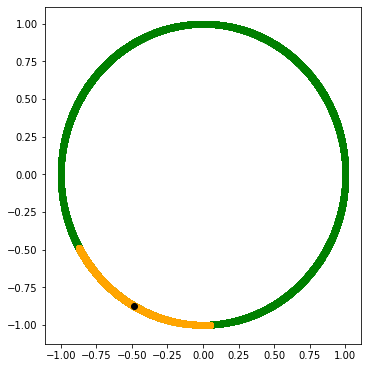

In [2]:
x = np.random.randn(10000)
y = np.random.randn(10000)

raw = np.vstack((x, y)) 
pts = raw / np.linalg.norm(raw, axis=0)

e1 = np.array([1, 0])
e2 = np.array([0, 1])

v = np.random.randn()*e1 + np.random.randn()*e2
v = v / np.linalg.norm(v, axis=0)

print(v)

txt = "Project all points onto the unit sphere, and then get the "

proj = np.dot(v, pts) 

fig = plt.figure(figsize=(5, 5), constrained_layout=True)
ax_array = fig.subplots(1, 1, squeeze=True)


# ax_array.scatter(*raw, c='green')
# ax_array.scatter(*(raw.T[proj > 0.85].T))
# ax_array.scatter(*v, c='black')

ax_array.scatter(*pts, c='green')
ax_array.scatter(*(pts.T[proj > 0.85].T), c='orange')
ax_array.scatter(*v, c='black')

# fig.text(.5, -0.1, txt, ha='center')

In [3]:
genomes = load_obj('.', 'genomes.pkl')

genomes.keys()

dict_keys(['re_many', 'noScore', 'minimal1', 'manydoors', 'wallnoScore', 'manyNoScore', 'solarfox', 'exp1'])

In [4]:
exp = 'manydoors'

# genomes[exp][194]

raw = {k:{"lvl":gen} for k, (gen, win) in sorted(genomes[exp].items())}
normalizedLvlCharacterization = np.array([gen / np.linalg.norm(gen) 
                                          for k, (gen, win) in sorted(genomes[exp].items())])

wins = np.array([win for k, (gen, win) in sorted(genomes[exp].items())])

In [5]:
normalizedLvlCharacterization[86].dot(normalizedLvlCharacterization[92])

0.9513666394753523

Get number of species  
Follow the levels as they were created

1. Normalize each level characterization (i.e. project onto the gauss sphere)
2. get the cos of the angle between prototypical vectors and if far enough away from all prototypes, then spawn a new species

In [6]:
speciationType = "projection"

In [7]:
def knnSpeciation(population, species, s_ids, cutoff):
    
    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=3)

    dataset = []
    dists   = []

    for j, v in enumerate(population):
        dataset.append(v)

        if len(dataset) > 3: 
            neigh.fit(dataset[:j]) # this is correct. We're measuring
                                   # this vector, v, against the previous stuff 
                                   # in the population EXCLUDING v.
        else:
            continue

        expanded = np.expand_dims(v, axis=0)
        dist, neighbors = neigh.kneighbors(expanded, return_distance=True)
        dists.append(np.mean(dist))
        if dists[-1] > cutoff:
            species.append(v)
            s_ids.append(j)
            
    return dists

In [8]:
def projectionSpeciation(population, species, s_ids, cutoff):

    for j, v in enumerate(population):
        dists = []
        for i, prototype in enumerate(species):
            proj = np.dot(v, prototype)
            dists.append([i, proj])
        if np.all(np.array(dists)[:, 1] < cutoff):
            species.append(v)
            s_ids.append(j)
    
    return

In [9]:
species = [normalizedLvlCharacterization[0]]
s_ids   = [0]

if speciationType == "knn":

    # edit species and s_ids in place
    cutoff = 0.37
    dists = knnSpeciation(normalizedLvlCharacterization, species, s_ids, cutoff)
    species = np.array(species)

    plt.plot(range(len(dists)), [cutoff]*len(dists), label='cutoff')
    plt.plot(dists, label='average distance to k-nn')
    plt.legend(loc='lower left')
    plt.suptitle(f'{exp} average distance from k-nearest neighbors plot over time')
    plt.show()
    
elif speciationType == "projection":
    
    cutoff = 0.85
    projectionSpeciation(normalizedLvlCharacterization, species, s_ids, cutoff)
    species = np.array(species)

else:
    raise ValueError("speciation method not supported")

In [10]:
s_ids

[0, 20, 78, 107, 578]

## Classify all levels into closest species representative

In [11]:
classification = [None] * normalizedLvlCharacterization.shape[0]

for j, v in enumerate(normalizedLvlCharacterization):
    proj = np.dot(species, v)
    family = np.argmax(proj)
    classification[j] = s_ids[family]

classification = np.array(classification)

In [12]:
# args = []

# for i, c in enumerate(classification):
#     if c == s_ids[-1]:
#         args.append(i)

In [13]:
np.unique(classification)

array([  0,  20,  78, 107, 578])

In [14]:
directions = load_obj('exactTransfers/', f"exactTransfers.{exp}.pkl")

In [15]:
directions[379] #PINSKY loop 
# (to, from)

[(89, 88),
 (102, 103),
 (90, 98),
 (86, 85),
 (101, 89),
 (75, 80),
 (97, 103),
 (81, 102),
 (87, 101),
 (94, 103),
 (103, 93),
 (104, 103),
 (92, 86)]

Get how normalizedLvlCharacterization transfers happened as a function of what species the incoming agent came from

In [16]:
from collections import defaultdict

In [17]:
speciatedTranfers = defaultdict(int)
from_outside = 0
from_inside = 0

for k, v in sorted(directions.items()):
    for _to, _from in v:

        speciatedTranfers[(classification[_to], classification[_from])] += 1        
        
        if classification[_to] != classification[_from]:
            from_outside += 1
        else:
            from_inside += 1
        
        

In [18]:
speciatedTranfers[(s_ids[0], s_ids[1])]

101

In [19]:
from_inside

5703

In [20]:
from_outside

2857

get breakdown of how normalizedLvlCharacterization levels belong to each species

Text(0, 0.5, 'number of levels')

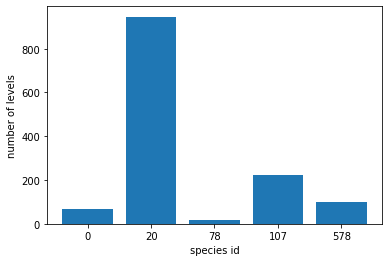

In [21]:
heights = []
for s in np.unique(classification):
    heights.append((s == classification).sum())

heights = np.array(heights)
    
fig, ax = plt.subplots(1, 1)
ax.bar(range(len(heights)), heights)
ax.set_xticks(range(len(heights)))
ax.set_xticklabels(s_ids)
ax.set_xlabel(f'species id')
ax.set_ylabel("number of levels")
#ax.set_title(f'breakdown of {exp}\'s species')

In [94]:
classColors = ['magenta', '#e1e63c', 'blue', '#d9d9d9', 'orange', "green", "pink", 'teal', 'red']

In [95]:
exps = ["multiDoor \n 1", "multiDoor \n 2", "multiDoor \n Aligned", 
        "singleDoor", "singleDoor \n Aligned 1", "singleDoor \n Aligned 2"]

id_tracks = [[0, 20, 78, 107, 578], 
             [0, 8, 10, 72, 385, 412, 1001], 
             [0, 19, 80, 462, 476, 650, 878, 1260], 
             [0, 31, 56, 137, 364], 
             [0, 45, 72, 83, 88, 343, 402, 478, 925],
             [0, 22, 49, 66, 122, 292, 317, 842]]

distributions = [[ 67, 946,  17, 224, 100], 
                 [ 57, 787,  16, 251,   7, 184,  33], 
                 [ 75, 600,  35, 442,   7,  74,   7, 105],
                 [ 72,  71,  92, 194, 256], 
                 [ 59,  23,  44, 293,  24,  81, 510, 269, 210], 
                 [ 51, 222,  14, 102,  20, 700,  14, 129]] 

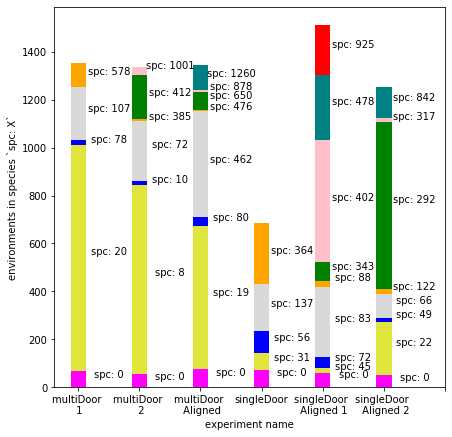

In [96]:
patch_handles = []

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

prev = 0
xplaces = []

for j, e in enumerate(exps):
    prev += 3
    xplaces.append(prev)
    dist = distributions[j]
    runningTotal = 0
    for i, _id in enumerate(id_tracks[j]):
        patch_handles.append(plt.bar(prev, dist[i], bottom=runningTotal, color=classColors[i], label=_id, width=0.75))
        
        
        patch = patch_handles[-1].get_children()[0]
        bl = patch.get_xy()
        x = 0.5*patch.get_width() + bl[0] + 1.5
        y = 0.5*patch.get_height() + bl[1] + 15*np.random.rand()
        ax.text(x,y, f"spc: {_id}", ha='center', c='black',)
               #bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 3})
        
        runningTotal += dist[i]
    # plt.legend()
    
xplaces.append(xplaces[-1] + 3)
plt.ylabel("environments in species `spc: X`")
plt.xlabel("experiment name")
plt.xticks(xplaces, exps)

plt.show()

In [97]:
np.sum(heights)

1354

show global trends transfer graph

In [98]:
def globalTransferBreakdown(to=True):

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    direction = ""
    if to:
        direction += 'to'
    else:
        direction += 'from'
    
    ax.plot(list(directions.keys()), smooth([len(v) for k, v in directions.items()], 5), label='total')

    for n, s in enumerate(np.unique(classification)):

        l = [0] * len(directions.keys())
        for i, (k, v) in enumerate(directions.items()):
            for _to, _from in v:
                if to:
                    if classification[_to] == s:
                        l[i] += 1
                else:
                    
                    if classification[_from] == s:
                        l[i] += 1

        ax.plot(list(directions.keys()), smooth(l, 5), c=classColors[n], label=f"species {s}")



    ax.set_yticks(range(0, 35, 5))

    ax.set_xlabel(f'PINSKY loop id')
    ax.set_ylabel("# transfers")
    # ax.set_title(f'breakdown of transfers {direction} species X')

    plt.legend(bbox_to_anchor=(1.12, 1), loc='upper right')

    return fig


# transfers = {}
# for e in genomes.keys():
#     transfers[e] = directions = load_obj('exactTransfers/', f"exactTransfers.{e}.pkl")

# labels = {}
# labels['exp1'] = "singleDoor"
# labels['noScore'] = "singleDoor Aligned 1"
# labels['wallnoScore'] = "singleDoor Aligned 2"
# labels['manyNoScore'] = 'multiDoor Aligned'
# labels['manydoors'] = "multiDoor 1"
# labels['re_many'] = "multiDoor 2"


# from math import floor

# fig, axes = plt.subplots(3, 2, figsize=(8, 4), sharey=True, sharex=True, constrained_layout=True)

# for i, e in enumerate(labels):
#     row = floor(i / 2)
#     col = col = i % 2 
#     ax = axes[row][col]
#     ax.plot(list(transfers[e].keys()), 
#              smooth([len(v) for k, v in transfers[e].items()], 5), 
#              alpha=0.75)
    
#     ax.set_yticks(range(0, 35, 5))
#     if i % 2 - 1: ax.set_ylabel("# transfers")
#     if i > 3: ax.set_xlabel("PINSKY loop id")
#     ax.set_title(f'{labels[e]}')
    

In [99]:
exp

'manydoors'

/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.


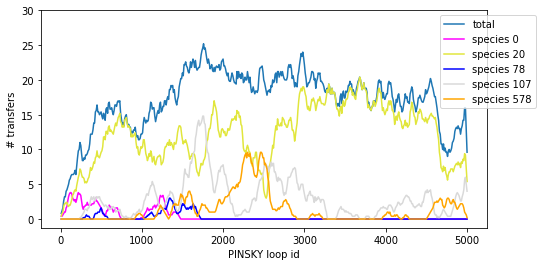

In [100]:
globalTransferBreakdown(True).show()

/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.


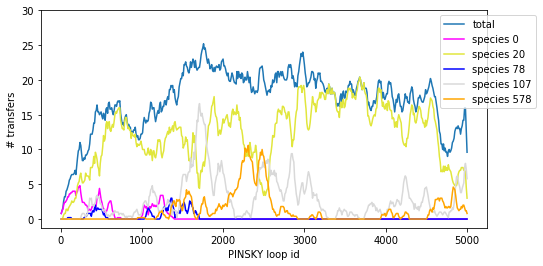

In [101]:
globalTransferBreakdown(False).show()

/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


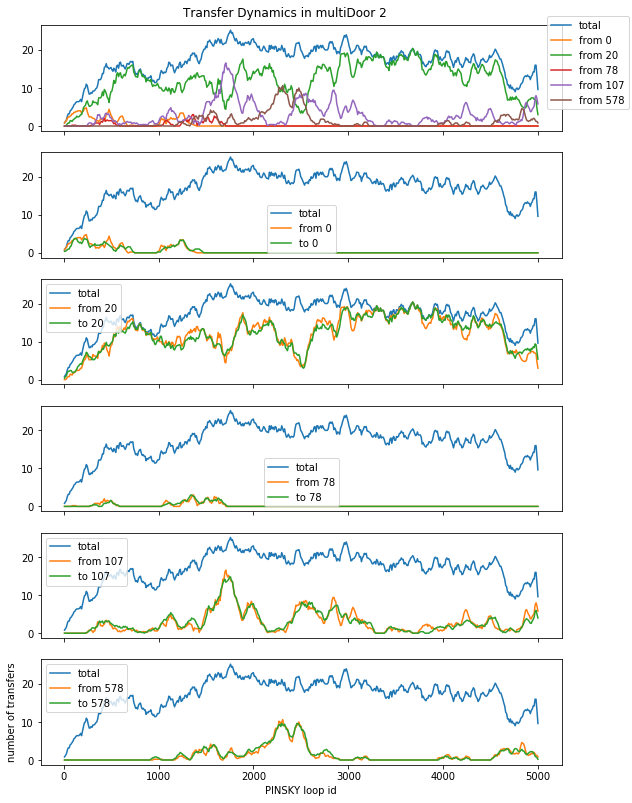

In [90]:
fig, axes = plt.subplots(len(s_ids) + 1, 1, sharey=True, sharex=True, figsize=(8, 11))

axes[0].plot(list(directions.keys()), smooth([len(v) for k, v in directions.items()], 5), label='total')

for s in np.unique(classification):

    l = [0] * len(directions.keys())
    for i, (k, v) in enumerate(directions.items()):
        for _to, _from in v:
            if classification[_from] == s:
                l[i] += 1

    axes[0].plot(list(directions.keys()), smooth(l, 5), label=f"from {s}")


    # axes[0].set_yticks(range(0, 35, 5))

fig.legend(bbox_to_anchor=(1.1, 1), loc='upper right')

for i, ax in enumerate(axes):
    if i == 0: 
        continue

    ax.plot(list(directions.keys()), smooth([len(v) for k, v in directions.items()], 5), label='total')


    s = s_ids[i - 1]

    fromS = [0] * len(directions.keys())
    toS = [0] * len(directions.keys())

    for i, (k, v) in enumerate(directions.items()):
        for _to, _from in v:
            if classification[_from] == s:
                fromS[i] += 1
            if classification[_to] == s:
                toS[i] += 1

    ax.plot(list(directions.keys()), smooth(fromS, 5), label=f"from {s}")
    ax.plot(list(directions.keys()), smooth(toS, 5), label=f"to {s}")

    # ax.set_yticks(range(0, 35, 5))


    # ax.set_ylabel("number of transfers")
    # ax.set_title(f'breakdown of {exp}\'s transfers to and from species {s}')

    ax.legend()

axes[-1].set_ylabel("number of transfers")

ax.set_xlabel(f'PINSKY loop id')
    
fig.show()

plt.suptitle(f"Transfer Dynamics in multiDoor 2", y=1.01)
plt.tight_layout()

In [30]:
percentTransferBySpecies = {}
percentTransferBySpecies['total'] = 0

for (_to, _from), v in speciatedTranfers.items():
    percentTransferBySpecies['total'] += v

for s_id in s_ids: 
    percentTransferBySpecies[s_id] = defaultdict(int)

    for (_to, _from), v in speciatedTranfers.items():
        if _to == s_id or _from == s_id:
            percentTransferBySpecies[s_id][(_to, _from)] = v / percentTransferBySpecies['total'] * 100
    


In [31]:
# pprint(percentTransferBySpecies)

In [32]:
import seaborn as sb

In [33]:
mat = np.zeros((len(s_ids), len(s_ids)))

In [34]:
for i, a in enumerate(s_ids):
    for j, b in enumerate(s_ids):
        try:
            mat[i][j] = percentTransferBySpecies[a][(a, b)]
        except KeyError as e:
            mat[i][j] = 0

In [35]:
exp

'manydoors'

Text(33.0, 0.5, 'from species')

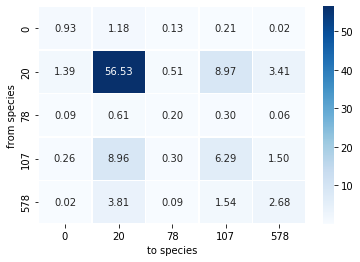

In [36]:
fig, ax = plt.subplots(1, 1)

sb.heatmap(mat, cmap="Blues", annot=True, fmt=".2f", linewidth=0.5, ax=ax)
ax.set_xticklabels(s_ids)
ax.set_yticklabels(s_ids, va='center')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.xlabel("to species")
plt.ylabel("from species")

In [37]:
node_count = 105

In [38]:
classification[:node_count]

array([  0,   0,   0,   0,   0,   0,   0,  20,   0,  20,   0,  20,  20,
        20,   0,  20,   0,   0,   0,   0,  20,   0,  20,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  78,   0,   0,   0,   0,  20,   0,
        20,   0,   0,  20,   0,  20,  20,  20,   0,  20,   0,   0,   0,
        20,  20,  20,  20,  20,  20,   0,   0,  20,   0,  20,  20,  20,
         0,   0,  20,   0,  20,  20,  20,   0,  20,  20, 107,   0,  20,
        78,  20, 107,   0,   0,  20,  20,  20,  20,  20,  20, 107,   0,
         0,  20,  78,  20, 107,   0,  20,   0,  20, 107,  20,  20, 107,
        20])

In [39]:
solved_with_help = defaultdict(int)
percent_outside = defaultdict(float)

for i, node_solved_status in enumerate(wins):
    from_inside = 0
    from_outside = 0
    total = 0
    species_id = classification[i]
    for loop_id, transfers in directions.items():
        array = np.array(transfers)
        if not np.any(array):
            continue
        try:
            relevant_data = array[array[:, 0] == i].squeeze()
        except IndexError as e:
            print(array)
        # print(loop_id, relevant_data)
        if not relevant_data.any():
            continue
        newcomer = classification[relevant_data[1]]
        if species_id == newcomer:
            from_inside += 1
        else:
            from_outside += 1
            
    if from_outside and wins[i]:
        solved_with_help[i] = True
        percent_outside[i] = from_outside / (from_inside + from_outside)

Text(0, 0.5, 'percent of outside-species transfer')

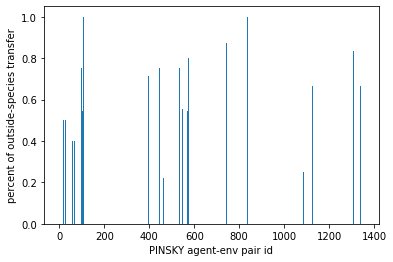

In [40]:
plt.bar(range(len(wins)), [percent_outside[p] for p in range(len(wins))])
plt.xlabel(f'PINSKY agent-env pair id')
plt.ylabel(f'percent of outside-species transfer')

In [41]:
sum(wins) / len(wins)

0.12850812407680945

In [42]:
len([v for k, v in percent_outside.items() if v > 0]) / sum(wins)

0.7586206896551724

```
manydoors 1 =           75% solved levels have tranfser from outside of species  
manyDoors 2 =           49% solved levels have tranfser from outside of species  
manyDoors aligned =     47% solved levels have tranfser from outside of species  

singleDoor =            72% solved levels have tranfser from outside of species  
singleDoor aligned 1 =  39% solved levels have tranfser from outside of species  
singleDoor aligned 2 =  41% solved levels have tranfser from outside of species  

```

In [43]:
exp

'manydoors'

In [44]:
manydoors = load_obj('./lineages/', f'{exp}.lineage.pkl')

In [45]:
import igraph

In [46]:
edges = []

for i in range(node_count):
    lineage = manydoors[i]
    try:
        edges.append((lineage[1], lineage[0]))
    except IndexError as e:
        continue
        
x = directions[379]

oneStepTransfer = []
edges_to = []
edges_from = []
for i, (_to, _from) in enumerate(x):
    edges_to.append(_to)
    edges_from.append(_from)
    
    oneStepTransfer.append((_from, _to))
    
# g.add_edges(x)

In [47]:
x

[(89, 88),
 (102, 103),
 (90, 98),
 (86, 85),
 (101, 89),
 (75, 80),
 (97, 103),
 (81, 102),
 (87, 101),
 (94, 103),
 (103, 93),
 (104, 103),
 (92, 86)]

In [48]:
g = igraph.Graph(directed=True)

g.add_vertices(node_count)
g.add_edges(edges)# + z)

In [49]:
edges

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (3, 7),
 (2, 8),
 (3, 9),
 (4, 10),
 (4, 11),
 (3, 12),
 (2, 13),
 (8, 14),
 (9, 15),
 (3, 16),
 (5, 17),
 (5, 18),
 (1, 19),
 (13, 20),
 (2, 21),
 (11, 22),
 (2, 23),
 (2, 24),
 (4, 25),
 (18, 26),
 (9, 27),
 (0, 28),
 (7, 29),
 (0, 30),
 (18, 31),
 (4, 32),
 (16, 33),
 (32, 34),
 (21, 35),
 (24, 36),
 (15, 37),
 (14, 38),
 (28, 39),
 (33, 40),
 (14, 41),
 (16, 42),
 (36, 43),
 (11, 44),
 (15, 45),
 (26, 46),
 (38, 47),
 (42, 48),
 (41, 49),
 (23, 50),
 (18, 51),
 (42, 52),
 (21, 53),
 (37, 54),
 (39, 55),
 (55, 56),
 (32, 57),
 (31, 58),
 (43, 59),
 (52, 60),
 (43, 61),
 (34, 62),
 (52, 63),
 (54, 64),
 (51, 65),
 (58, 66),
 (42, 67),
 (50, 68),
 (37, 69),
 (47, 70),
 (67, 71),
 (50, 72),
 (52, 73),
 (54, 74),
 (56, 75),
 (42, 76),
 (64, 77),
 (59, 78),
 (54, 79),
 (75, 80),
 (59, 81),
 (79, 82),
 (79, 83),
 (67, 84),
 (73, 85),
 (52, 86),
 (71, 87),
 (74, 88),
 (80, 89),
 (66, 90),
 (70, 91),
 (87, 92),
 (69, 93),
 (79, 94),
 (8

In [50]:
len(["circle" for _ in range(node_count - 33)] + ['square' for _ in range(33)])

105

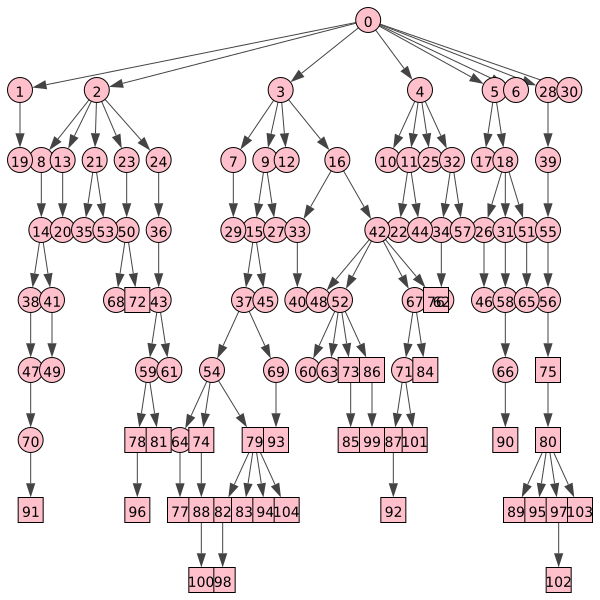

In [51]:
g.vs["name"] = list(range(node_count))

visual_style = {}
visual_style["vertex_label"] = g.vs["name"]
visual_style["vertex_color"] = "pink"
visual_style["vertex_size"] = 25
visual_style['vertex_shape'] = ["circle" for _ in range(node_count - 33)] + ['square' for _ in range(33)]

layout = g.layout_reingold_tilford()
igraph.plot(g, layout=layout, **visual_style)

In [52]:
g.add_edges(oneStepTransfer)

g.vcount()

105

In [53]:
uniqueClassLabels = np.unique(classification[:node_count])
uniqueClassLabels

array([  0,  20,  78, 107])

In [54]:
colors = [None] * len(g.es)
counted = defaultdict(int)

for i, e in enumerate(g.es):
    #print(e.target, e.source)
    for j in range(len(edges_to)):
        if (e.source, e.target) in oneStepTransfer and not counted[(e.source, e.target)]:
            # e.target == edges_to[j] and e.source == edges_from[j]
            colors[i] = "red"
            counted[(e.source, e.target)] += 1
            break
        else:
            if colors[i] is None:
                colors[i] = 'black'
            else:
                continue

In [55]:
classColors = ['pink', 'yellow', 'light blue', 'white', 'orange', "green", "magenta"]

nodeColors = []
for node_ in range(node_count):
    for i, v in enumerate(uniqueClassLabels):
        if classification[:node_count][node_] == v:
            nodeColors.append(classColors[i])
            break

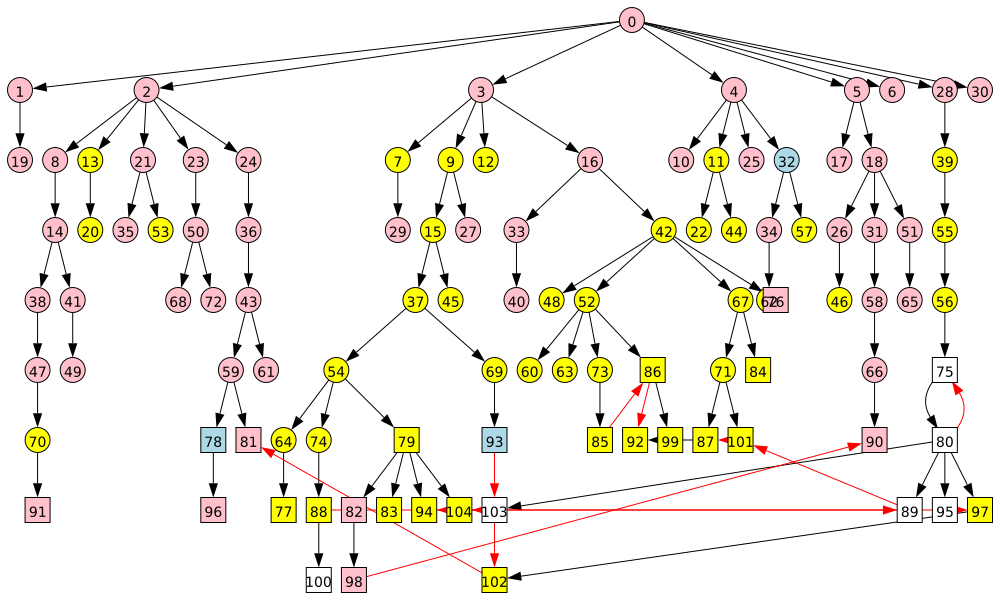

In [62]:
visual_style = {}
visual_style["vertex_label"] = g.vs["name"]
visual_style["vertex_color"] = nodeColors
visual_style["vertex_size"] = 25
visual_style['vertex_shape'] = ["circle" for _ in range(node_count - 30)] + ['square' for _ in range(30)]
visual_style["bbox"] = (1000, 600)

g.es["color"] = colors
g.vs['shape'] = ["circle" for _ in range(node_count - 30)] + ['square' for _ in range(30)]
g.vs['color'] = nodeColors

layout = g.layout_reingold_tilford()
image = igraph.plot(g, layout=layout, **visual_style)

image.save(f'./lineages/{exp}.transfer.png')
image

In [63]:
visual_style = {}
visual_style['width'] = 1000
visual_style['height'] = 600
visual_style['layout'] = 'reingold_tilford'
visual_style["labels"] = g.vs["name"]
visual_style['shapes'] = ["circle" for _ in range(node_count - 30)] + ['square' for _ in range(30)]
# visual_style['vertex_label_size'] = 5
# visual_style['vertex_label_color'] = 'blue'
visual_style['colors'] = nodeColors
visual_style['edge_colors'] = colors
# visual_style['vertex_size'] = 10
# visual_style["edge_stroke_widths"] = normWeight

g.write_svg(f"./lineages/{exp}.transfer.svg", **visual_style)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
transformed = pca.fit_transform(normalizedLvlCharacterization)

In [ ]:
print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(transformed[:, 0], transformed[:, 1])#, transformed[:, 2])